In [1]:
!pip install pyspark -q
!pip install findspark -q

In [1]:
# Import the cleaned dataset (gold layer)
from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("LoadGold").getOrCreate()

df = (spark.read
          .option("header", True)
          .option("inferSchema", True)
          .option("sep", ";")
          .csv('/content/drive/MyDrive/datasets/gold_fact_events.csv')
)

Mounted at /content/drive


In [2]:
# Number by events
dist_events = (
    df.groupBy("event_type")
    .count()
    .orderBy("count", ascending=False)
)
dist_events.show()

+-----------+-------+
| event_type|  count|
+-----------+-------+
|       view|2661699|
|  addtocart|  67055|
|transaction|  22451|
+-----------+-------+



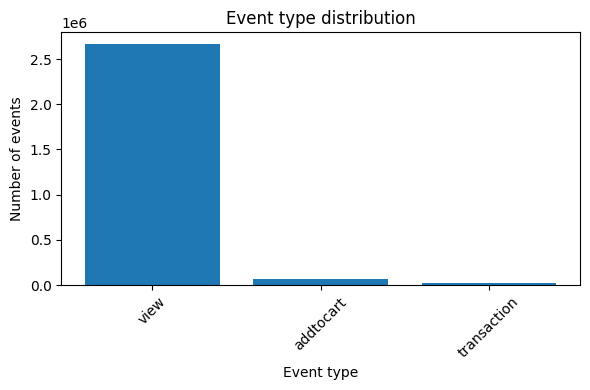

In [9]:
# dist_events vizualisation
pdf = dist_events.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(pdf["event_type"], pdf["count"])
plt.title("Event type distribution")
plt.xlabel("Event type")
plt.ylabel("Number of events")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

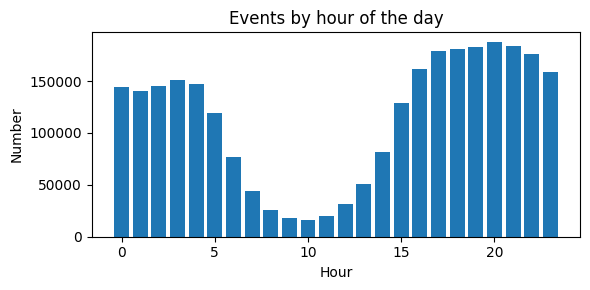

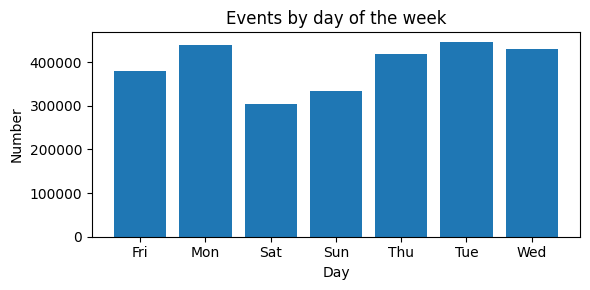

In [10]:
# Ts visualisation
from pyspark.sql import functions as F

time_df = (
    df
    .withColumn("hour", F.hour("event_ts"))
    .withColumn("dow", F.date_format("event_ts", "E"))
)

hourly = time_df.groupBy("hour").count().orderBy("hour")
dow    = time_df.groupBy("dow").count().orderBy("dow")

hourly_pd = hourly.toPandas()
dow_pd    = dow.toPandas()

# Hour visualisation
plt.figure(figsize=(6,3))
plt.bar(hourly_pd["hour"], hourly_pd["count"])
plt.title("Events by hour of the day")
plt.xlabel("Hour")
plt.ylabel("Number")
plt.tight_layout()
plt.show()

# Dat visualisation
plt.figure(figsize=(6,3))
plt.bar(dow_pd["dow"], dow_pd["count"])
plt.title("Events by day of the week")
plt.xlabel("Day")
plt.ylabel("Number")
plt.tight_layout()
plt.show()

In [11]:
# Top 10 most viewed products
top_views = (
    df.filter("event_type='view'")
      .groupBy("item_id")
      .count()
      .orderBy("count", ascending=False)
      .limit(10)
)

# Top 10 transactions
top_transactions = (
    df.filter("event_type='transaction'")
    .groupBy("item_id")
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
)

print("Top 10 most viewed products :")
top_views.show()

print("Top 10 most purchased products")
top_transactions.show()


Top 10 most viewed products :
+-------+-----+
|item_id|count|
+-------+-----+
| 187946| 3409|
| 461686| 2534|
|   5411| 2321|
| 370653| 1854|
| 219512| 1736|
| 298009| 1640|
|  96924| 1631|
| 309778| 1565|
| 257040| 1529|
| 384302| 1527|
+-------+-----+

Top 10 most purchased products
+-------+-----+
|item_id|count|
+-------+-----+
| 461686|  133|
| 119736|   97|
| 213834|   92|
| 312728|   46|
|   7943|   46|
| 445351|   45|
|  48030|   41|
| 420960|   38|
| 248455|   38|
|  17478|   37|
+-------+-----+



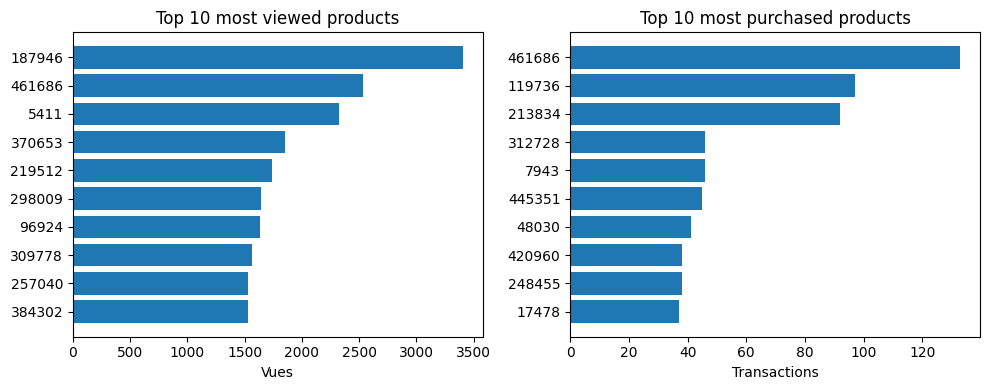

In [13]:
# Top views/transactions visualisation
v_pdf = top_views.toPandas()
t_pdf = top_transactions.toPandas()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.barh(v_pdf["item_id"].astype(str), v_pdf["count"])
plt.title("Top 10 most viewed products")
plt.xlabel("Vues")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.barh(t_pdf["item_id"].astype(str), t_pdf["count"])
plt.title("Top 10 most purchased products")
plt.xlabel("Transactions")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [17]:
# Viewed/Purchased by visitor ratio
user_beh = (
    df.groupBy("visitor_id", "event_type")
      .count()
      .groupBy("visitor_id")
      .pivot("event_type", ["view", "addtocart", "transaction"])
      .sum("count")
      .na.fill(0)
      .withColumn("conv_rate", F.col("transaction")/F.col("view"))
)

user_beh.select("visitor_id","view","transaction","conv_rate") \
         .orderBy("conv_rate", ascending=False) \
         .limit(10) \
         .show()

+----------+----+-----------+---------+
|visitor_id|view|transaction|conv_rate|
+----------+----+-----------+---------+
|    693528|   1|          6|      6.0|
|    472290|   1|          5|      5.0|
|    687602|   1|          4|      4.0|
|    586427|   1|          4|      4.0|
|     82318|   1|          4|      4.0|
|   1199640|   1|          4|      4.0|
|    972040|   1|          4|      4.0|
|   1206963|   1|          4|      4.0|
|    287930|   1|          3|      3.0|
|     48728|   1|          3|      3.0|
+----------+----+-----------+---------+

